In [5]:
%pip install torch torchvision
%pip install opencv-contrib-python
%pip install scikit-learn
%pip install matplotlib
%pip install pandas
%pip install numpy

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\proky\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [127]:
# OUR SOURCE : https://blog.paperspace.com/object-localization-pytorch-2/
# Python 3-9

import random
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.datasets import KMNIST
from torch.optim import Adam
from torch import nn
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
import torch
import time
import PIL
from torch import optim
import os
from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch import flatten
from torch import optim


In [128]:
train, test = train_test_split(pd.read_csv("../../annotation_dataset_formated.csv"),test_size=0.2)
img_dir = "../../dataset/"
print(test)

     filename  ax1  ay1  bx2  by2
65    65.jpeg  121  198  125  179
45    45.jpeg  110  199  115  188
41    41.jpeg  189  200  198  194
102  102.jpeg  125  198  122  183
37    37.jpeg   87  198   46  185
111  111.jpeg  173  200  160  180
86    86.jpeg  135  200  137  190
56    56.jpeg  102  197  131  179
22    22.jpeg  132  199   79  191
80    80.jpeg  161  199  131  173
26    26.jpeg  107  199   81  190
27    27.jpeg   22  198   19  186
12    12.jpeg  151  198  161  173
14    14.jpeg   51  199   18  183
63    63.jpeg  106  200  140  165
98    98.jpeg  128  198  157  172
113  113.jpeg  134  199  123  185
58    58.jpeg   89  183  120  163
0      0.jpeg   62  197   98  172
43    43.jpeg  127  198  110  189
2      2.jpeg  130  199  180  177
21    21.jpeg   79  197   79  184
29    29.jpeg  137  198  141  187


In [129]:
def open_images(paths):
        images = []
        for path in paths:
                with PIL.Image.open(img_dir + path) as image:
                        images.append(np.asarray(image))
                
        return np.array(images)

train_img = open_images(train["filename"])
test_img = open_images(test["filename"])
print(train_img.shape)

(91, 200, 200)


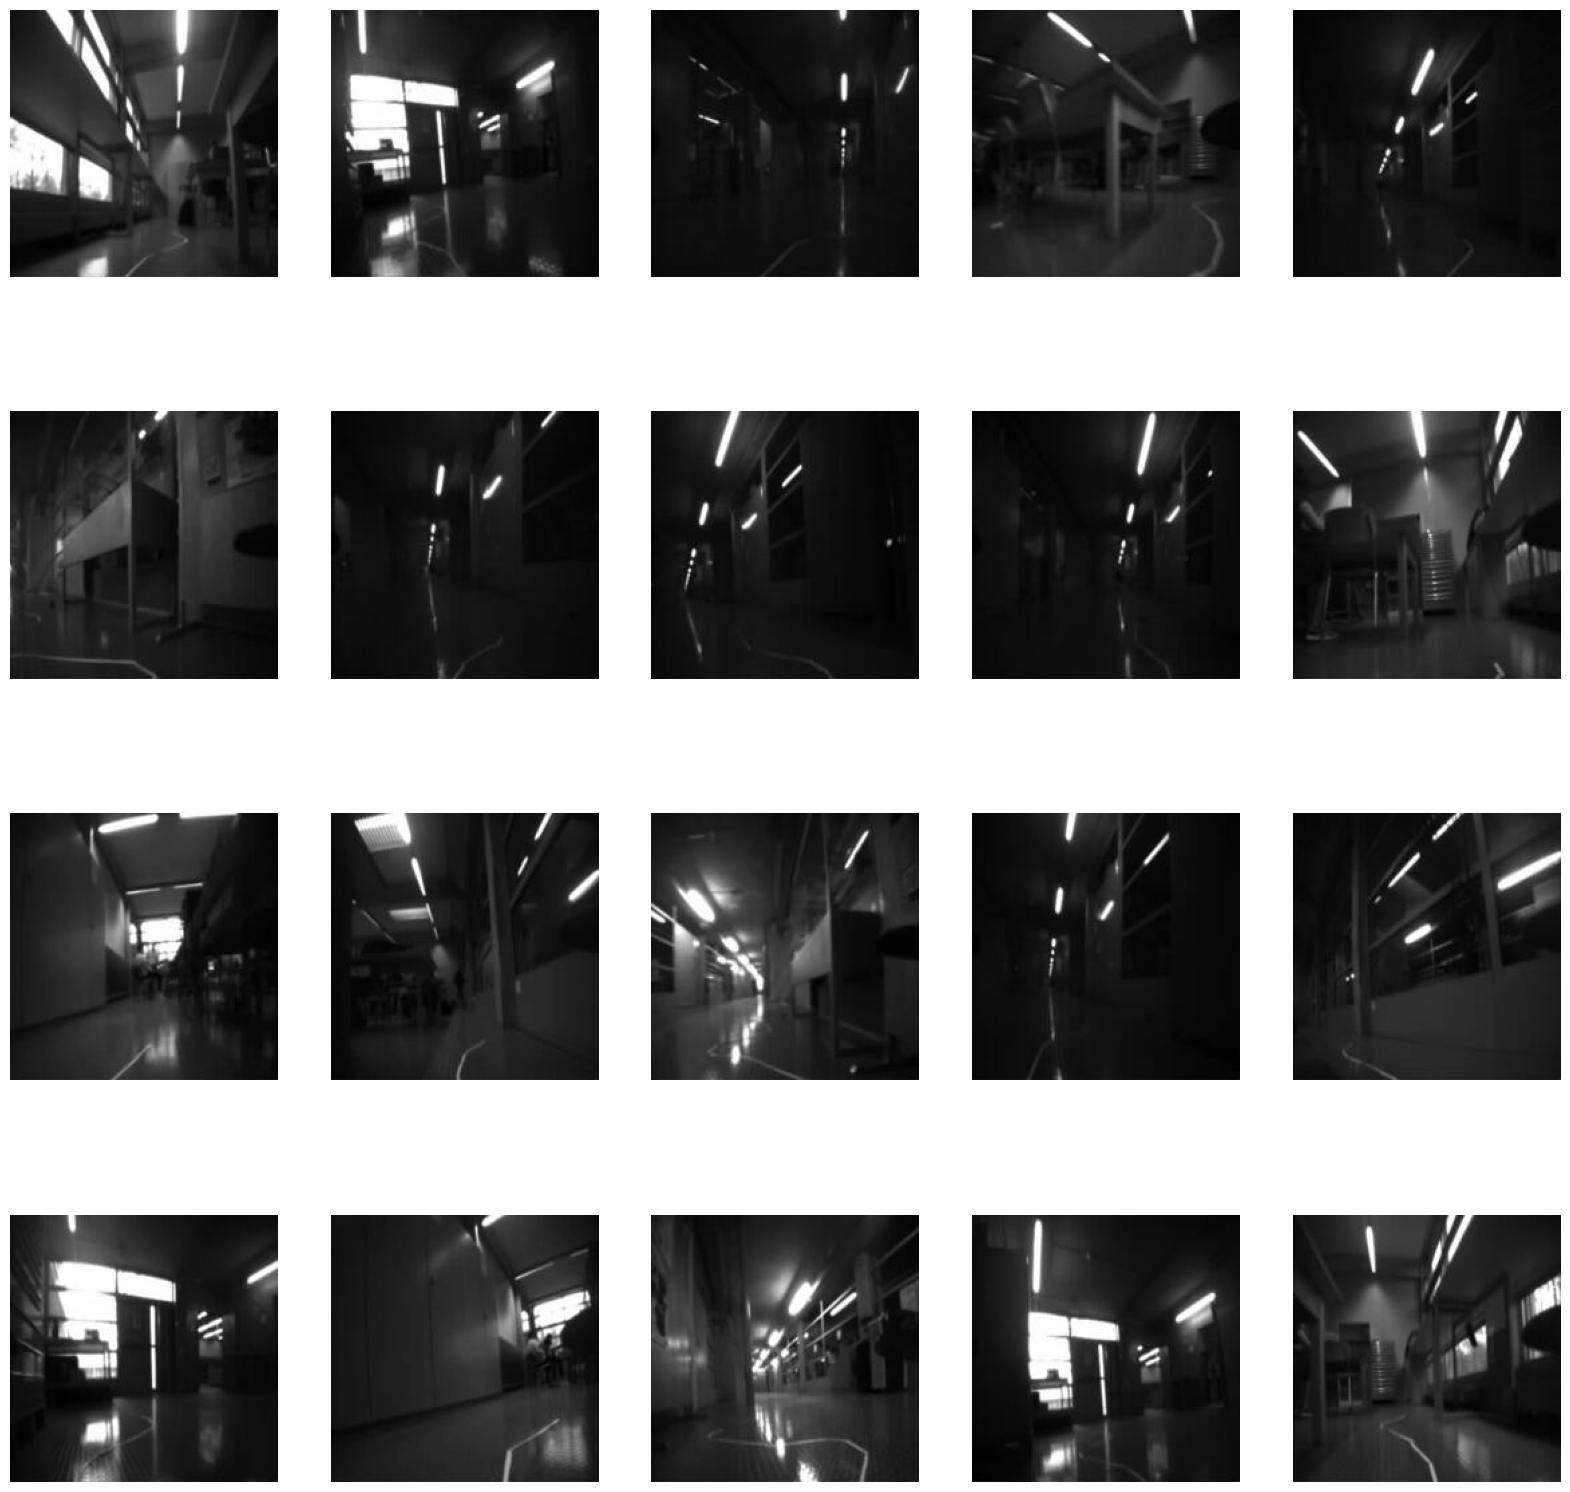

In [130]:
# Create a Matplotlib figure
plt.figure(figsize=(20,20))

# Generate a random sample of images each time the cell is run 
random_range = random.sample(range(1, len(train_img)), 20)

for itr, i in enumerate(random_range, 1):



    image = train_img[i]


# Clip the values to 0-1 and draw the sample of images
    
    plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
plt.show()


In [131]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [132]:
class Dataset():
    def __init__(self, train_images, train_coords):
        self.images = torch.from_numpy(train_images)
        self.coords = torch.from_numpy(train_coords)

    def __len__(self):
        return len(self.coords)

    # To return x,y values in each iteration over dataloader as batches.

    def __getitem__(self, idx):
        return (self.images[idx],
              self.coords[idx])

train_coords = train.loc[:,('ax1','ay1','bx2','by2')].values
test_coords = test.loc[:,('ax1','ay1','bx2','by2')].values

dataset_train = Dataset(train_img,train_coords)
dataset_test = Dataset(test_img,test_coords)


In [133]:
# OUR MODEL 
class CNN(Module):
    def __init__(self):
        # call the parent constructor
        super(CNN, self).__init__()

        # initialize first set of CONV => RELU => POOL layers
        self.conv1 = Conv2d(in_channels=1, out_channels=20,
            kernel_size=(5, 5))
        self.relu1 = ReLU()
        self.maxpool1 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize second set of CONV => RELU => POOL layers
        self.conv2 = Conv2d(in_channels=20, out_channels=50,
            kernel_size=(5, 5))
        self.relu2 = ReLU()
        self.maxpool2 = MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = Linear(in_features=50*47*47, out_features=500)
        self.relu3 = ReLU()
        # initialize our softmax classifier
        self.fc2 = Linear(in_features=500, out_features=4)

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = x.view(x.size(0), -1)  # flatten the tensor
        x = self.fc1(x)
        x = self.relu3(x)
        # pass the output to get our output
        # predictions
        output = self.fc2(x)
        # return the output predictions
        return output
model = CNN()
model = model.to(device)
model

CNN(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=110450, out_features=500, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=500, out_features=4, bias=True)
)

In [134]:
dataloader = torch.utils.data.DataLoader(
       dataset_train, batch_size=32, shuffle=True)
valdataloader = torch.utils.data.DataLoader(
       dataset_test, batch_size=32, shuffle=True)

In [135]:

# OUR TRAINING function

def train(model, dataloader, valdataloader, epochs=10, lr=0.001):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(dataloader, 0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs.unsqueeze(1).float())
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print('[%d, %5d] loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / 100))
                running_loss = 0.0
    print('Finished Training')
    return model


In [136]:
model = train(model, dataloader, valdataloader, epochs=10, lr=0.001)

Finished Training


In [137]:

def test(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images.unsqueeze(1).float())
            total += labels.size(0)
            correct += ((outputs - labels.float())**2).sum().item()
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))
    return correct / total

In [138]:

test(model, valdataloader)

Accuracy of the network on the test images: 1532203 %


15322.03125

In [139]:
def predict(model , image):
    model.eval()
    with torch.no_grad():
        image = torch.from_numpy(image).float()
        image = image.to(device)
        outputs = model(image.unsqueeze(0).unsqueeze(0))
    return outputs.cpu().numpy().flatten()

In [140]:

# OUR PREDICTION
image = test_img[0]
print(image.shape)
pred = predict(model, image)
print(pred)
print(test_coords[0])


(200, 200)
[ 70.831566 103.63485   58.692387  86.57265 ]
[121 198 125 179]


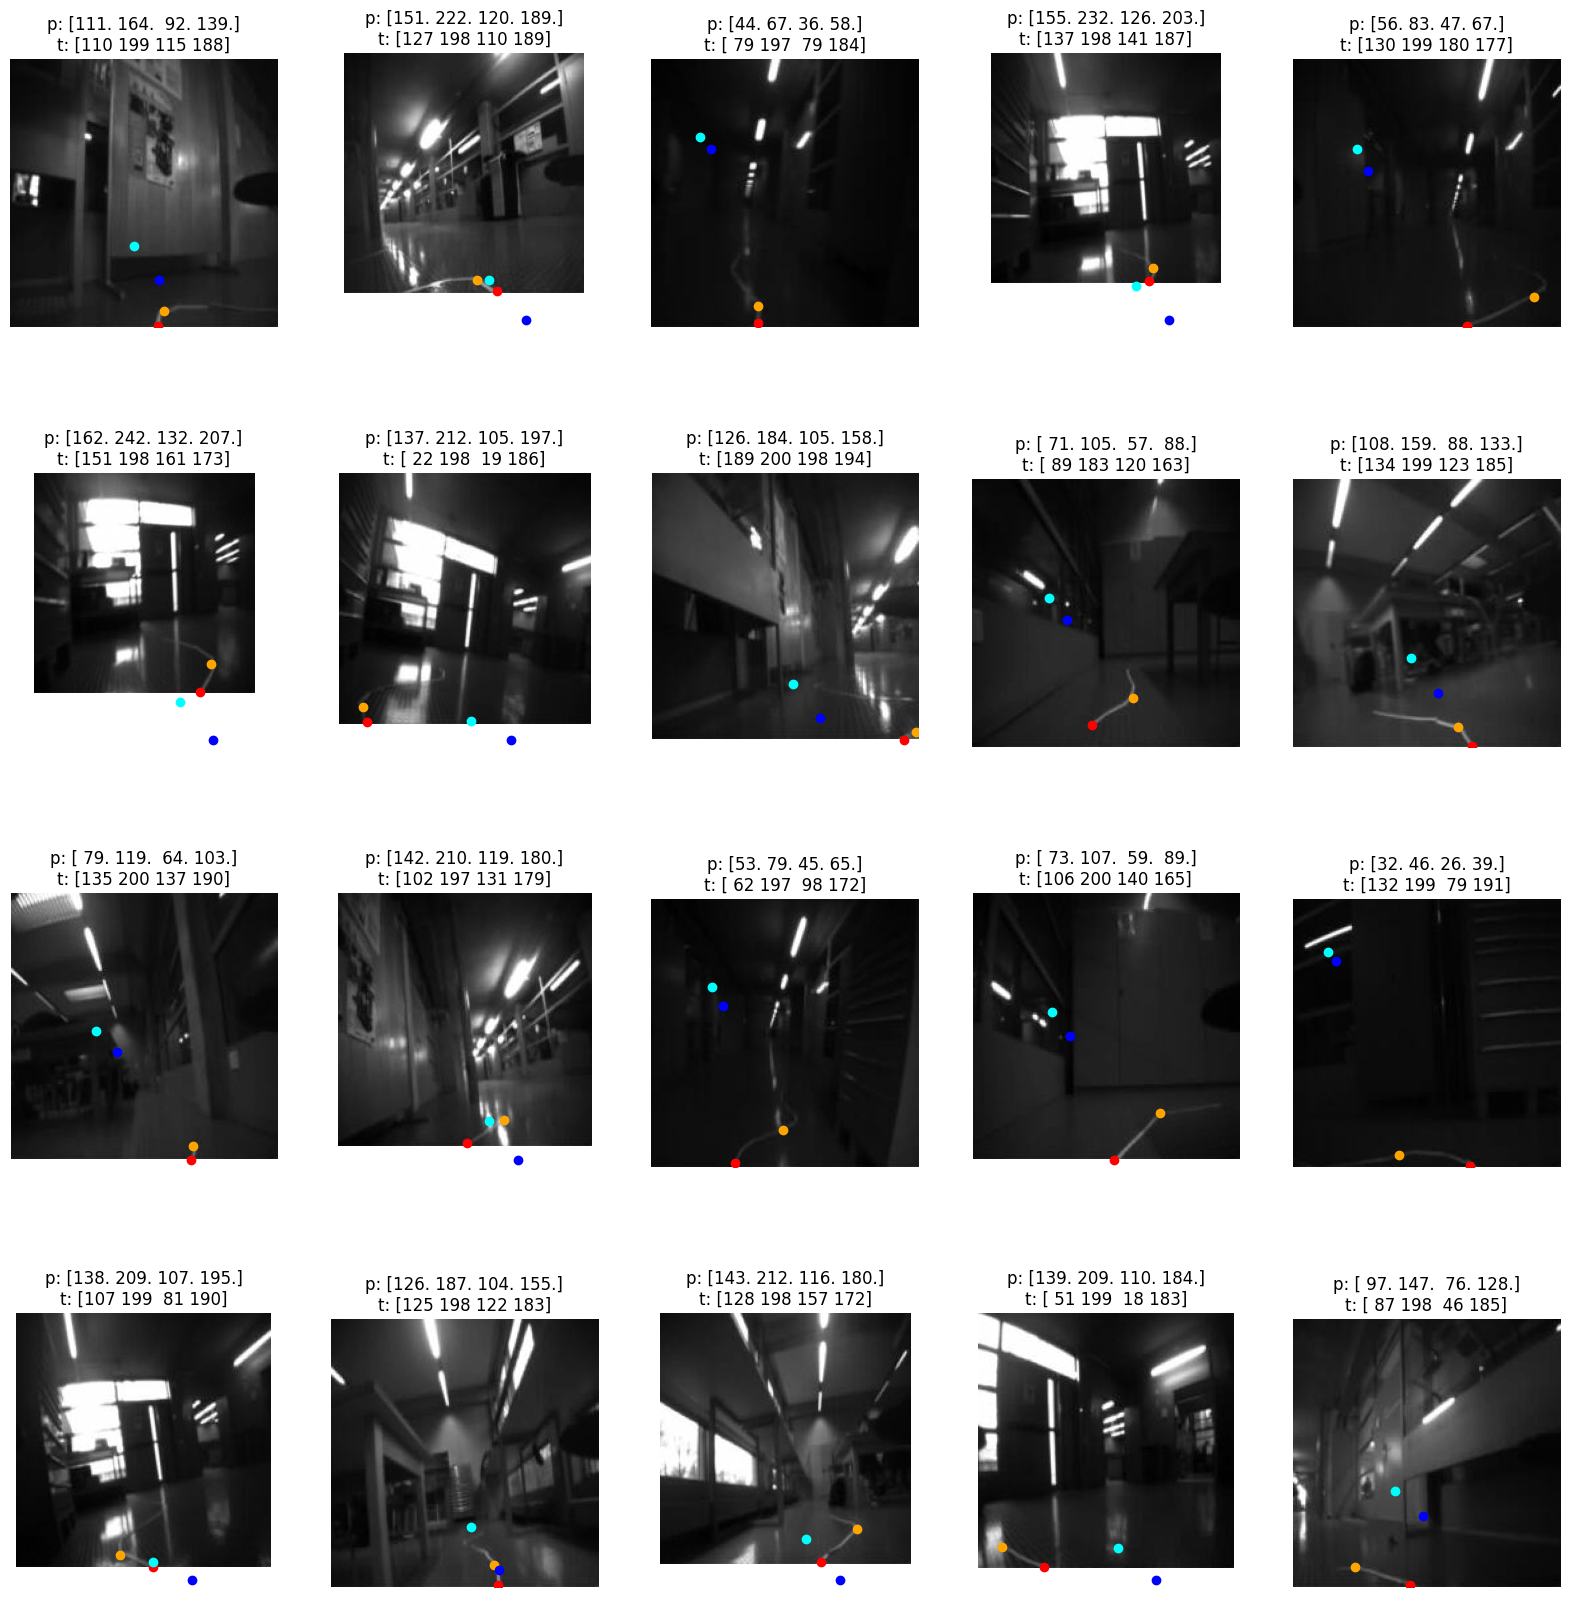

In [141]:
# Generate a random sample of images each time the cell is run
random_range = random.sample(range(1, len(test_img)), 20)

# Create a Matplotlib figure
plt.figure(figsize=(20,20))

for itr, i in enumerate(random_range, 1):
    image = test_img[i]
    coords = test_coords[i]
    output = predict(model, image)

    # Clip the values to 0-1 and draw the sample of images
    plt.subplot(4, 5, itr)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.title("p: " + str(np.round(output)) + "\nt: " + str(coords))

    # Plot the ground truth points with red variation
    plt.scatter(coords[0], coords[1], c='red', marker='o', label='Ground Truth A')
    plt.scatter(coords[2], coords[3], c='orange', marker='o', label='Ground Truth B')

    # Plot the prediction points with blue variation
    plt.scatter(output[0], output[1], c='blue', marker='o', label='Prediction A')
    plt.scatter(output[2], output[3], c='cyan', marker='o', label='Prediction B')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Show the plot
plt.show()
